In [53]:
from typing import Annotated
from typing_extensions import TypedDict
import re
import json
import random

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langchain_core.tools import render_text_description
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage, ToolCall

from src.agent.ShellTool import ShellTool
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.messages import ToolMessage
from langgraph.checkpoint.memory import MemorySaver


In [54]:
# setup all tools
shell_tool = ShellTool()
tools = [shell_tool]

rendered_tools = render_text_description(tools)
print(rendered_tools)

Shell Execute Tool - useful when bash commands should be executed in the shell, the shell is kept alive therefore commands influence the future state and future commands


In [55]:
# system prompt and ad-hoc tool learning - Ollama does not support the default tools usage api - therefore we have to add ad-hoc tool learning
system_prompt = """
You are an assistant capable of executing simple bash tasks and responding to general user messages.

If you receive a task where you have to use the shell you can use the following tool to execute shell commands:
Shell Execute Tool - useful when bash commands should be executed in the shell, the shell is kept alive therefore commands influence the future state and future commands

When a user request could benefit from executing a shell command — either to complete the task or gather additional information — use the tool.

When you receive a task that includes shell command, first think step by step and provide a plan that includes all commands that should be executed. 

Then after you came up with a plan that includes one or multiple shell commands, wait until the tool is executed and you gathered all necessary information and then provide a final comprehensive textual answer to the task, that does NOT include any tool calls.

**Tool Use Format:**
When a shell command needs to be executed, format the command using the following JSON block:
```json
{{
  "name": "Shell Execute Tool",
  "arguments": {{
    "command": "YOUR_COMMAND_HERE"
  }}
}}
```
"""

In [56]:
# define general state structure
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [57]:
# system prompt - using prompt template
prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt), ("user", "{input}")]
)

In [58]:
# define chatbot node
llm = ChatOllama(model="llama3.1:8b")
#llm = ChatOllama(model="deepseek-r1:14b")
chain = prompt | llm

def chatbot(state: State):
    user_in = state["messages"]
    response = chain.invoke({"input": user_in})
    r_text = response.content
    
    try:
        # get all jsons
        while True:  # todo refactor -> use regex
            json_start_idx = r_text.find("```json")
            json_end_idx = -1
            if json_start_idx != -1:
                json_end_idx = r_text[json_start_idx + 7 :].find("```")
            if json_start_idx == -1 or json_end_idx == -1:
                break
            json_end_idx = json_start_idx + 7 + json_end_idx
            json_obj = json.loads(r_text[json_start_idx + 7 : json_end_idx])
            r_text = r_text[json_end_idx + 3 :]
            tool_call = ToolCall(
                name=json_obj["name"], 
                args=json_obj["arguments"],
                id=str(random.randint(1000, 9999))
            )
            response.tool_calls.append(tool_call)
            
    except Exception as e:
        print("-- chatbot node tool failed to parse jsons in: {}".format(response.content))
        print("-- {}".format(e))
            
    # return in the format your graph expects -> updates state
    return {"messages": response}

# first argument: node name, second: actual function that will be called
graph_builder.add_node("chatbot", chatbot)

In [59]:
# create a tool node - runs the tools requested in the last AIMessage
class ToolNode:

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, state: dict):
        
        ai_message = state["messages"][-1]
        outputs = []
        for tool_call in ai_message.tool_calls:
            try:
                tool = self.tools_by_name[tool_call["name"]]
                tool_result = tool.invoke(
                    tool_call["args"]
                )
                tool_message = ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
                outputs.append(tool_message)

            except Exception as e:
                print("BasicToolNode - tool calling with {} failed: ".format(tool_call))
                print(e)
                
        # return in the format your graph expects -> updates state
        return {"messages": outputs}

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [60]:
def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [61]:
# compile the graph to make it ready to be executed
# adding a checkpointer - todo descr
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

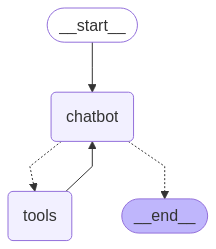

In [62]:
# visualization
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [63]:
# run the chatbot
      
# memory/snapshot setup      
config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    )
    for event in events:
        event["messages"][-1].pretty_print()
    

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]: break
    stream_graph_updates(user_input)

content='hi' additional_kwargs={} response_metadata={} id='186ecfbd-c62e-4207-8df1-52afb3d79317'
content='Hi there! How can I assist you today?' additional_kwargs={} response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-05-02T22:15:28.332935Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3325805792, 'load_duration': 745056792, 'prompt_eval_count': 281, 'prompt_eval_duration': 2364652000, 'eval_count': 11, 'eval_duration': 214684916, 'model_name': 'llama3.1:8b'} id='run-7a4dec9e-c305-4cc7-9219-36954f43e20e-0' usage_metadata={'input_tokens': 281, 'output_tokens': 11, 'total_tokens': 292}


In [64]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='186ecfbd-c62e-4207-8df1-52afb3d79317'), AIMessage(content='Hi there! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-05-02T22:15:28.332935Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3325805792, 'load_duration': 745056792, 'prompt_eval_count': 281, 'prompt_eval_duration': 2364652000, 'eval_count': 11, 'eval_duration': 214684916, 'model_name': 'llama3.1:8b'}, id='run-7a4dec9e-c305-4cc7-9219-36954f43e20e-0', usage_metadata={'input_tokens': 281, 'output_tokens': 11, 'total_tokens': 292})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f027a2f-42e7-6286-8001-5d40d81800c0'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': AIMessage(content='Hi there! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b

In [65]:
snapshot.next  # shows next node that will be executed it the graph was interrupted

()